In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
from sorted_crates import *
from top_crates import *
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [4]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [5]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [6]:
# Whitelists
# 250
function_definitions_250_set = set([
    x
    for x in function_definitions.crate
    if x in sorted_crates[:250]
])
function_definitions_250 = function_definitions[
    function_definitions.crate.isin(function_definitions_250_set)
]
all_function_names_250 = set(function_definitions_250.def_path.unique())
unchecked_function_names_250 = get_unchecked_function_names(all_function_names_250)
unguarded_function_names_250 = get_unguarded_function_names(all_function_names_250)

# 500
function_definitions_500_set = set([
    x
    for x in function_definitions.crate
    if x in sorted_crates[:500]
])
function_definitions_500 = function_definitions[
    function_definitions.crate.isin(function_definitions_500_set)
]
all_function_names_500 = set(function_definitions_500.def_path.unique())
unchecked_function_names_500 = get_unchecked_function_names(all_function_names_500)
unguarded_function_names_500 = get_unguarded_function_names(all_function_names_500)

# 1000
function_definitions_1000_set = set([
    x
    for x in function_definitions.crate
    if x in sorted_crates[:1000]
])
function_definitions_1000 = function_definitions[
    function_definitions.crate.isin(function_definitions_1000_set)
]
all_function_names_1000 = set(function_definitions_1000.def_path.unique())
unchecked_function_names_1000 = get_unchecked_function_names(all_function_names_1000)
unguarded_function_names_1000 = get_unguarded_function_names(all_function_names_1000)

all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

In [7]:
# Calls
all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

# 250
#all_calls_250_set = set([
#    x
#    for x in all_calls.crate
#    if x in sorted_crates[:250]
#])
#all_calls_250 = all_calls[
#    all_calls.crate.isin(all_calls_250_set)
#]
#unsafe_calls_250 = all_calls_250.query("unsafety != 'Normal'")
#assert len(pd.unique(unsafe_calls_250.unsafety)) == 1

In [8]:
# Top X Crates
def norm(x):
    return x.lower().replace("-", "_")

top_250_compiling_crates = set(map(norm, sorted_crates[:250])) & set(map(norm, selected_builds.package.unique()))
top_250_crates_set = set(sorted_crates[:250])
top_250_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_250_crates_set)
top_250_builds = selected_builds[top_250_mask][
    ~selected_builds[top_250_mask]["package"].duplicated()
]
top_500_compiling_crates = set(map(norm, sorted_crates[:500])) & set(map(norm, selected_builds.package.unique()))
top_500_crates_set = set(sorted_crates[:500])
top_500_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_500_crates_set)
top_500_builds = selected_builds[top_500_mask][
    ~selected_builds[top_500_mask]["package"].duplicated()
]
top_1000_compiling_crates = set(map(norm, sorted_crates[:1000])) & set(map(norm, selected_builds.package.unique()))
top_1000_crates_set = set(sorted_crates[:1000])
top_1000_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_1000_crates_set)
top_1000_builds = selected_builds[top_1000_mask][
    ~selected_builds[top_1000_mask]["package"].duplicated()
]

In [9]:
print("Number of compiling crates in top 250:\t", len(top_250_compiling_crates))
print("Number of builds in top 250:\t\t", len(top_250_builds))
print("Number of expected crates in top 250:\t", len(sorted_crates[:250]))

Number of compiling crates in top 250:	 246
Number of builds in top 250:		 146
Number of expected crates in top 250:	 250


In [10]:
print("Number of compiling crates in top 500:\t", len(top_500_compiling_crates))
print("Number of builds in top 500:\t\t", len(top_500_builds))
print("Number of expected crates in top 500:\t", len(sorted_crates[:500]))

Number of compiling crates in top 500:	 487
Number of builds in top 500:		 293
Number of expected crates in top 500:	 500


In [11]:
print("Number of compiling crates in top 1000:\t", len(top_1000_compiling_crates))
print("Number of builds in top 1000:\t\t", len(top_1000_builds))
print("Number of expected crates in top 1000:\t", len(sorted_crates[:1000]))

Number of compiling crates in top 1000:	 948
Number of builds in top 1000:		 543
Number of expected crates in top 1000:	 1000


In [12]:
print("Number of selected builds:\t", len(selected_builds))
print("Number of crates total:\t\t", len(crates))

Number of selected builds:	 4608
Number of crates total:		 4608


In [13]:
# Unsafe Blocks
unsafe_blocks_250_set = set([
    x
    for x in unsafe_blocks.crate
    if x in sorted_crates[:250]
])
unsafe_blocks_250 = unsafe_blocks[
    unsafe_blocks.crate.isin(unsafe_blocks_250_set)
]

unsafe_blocks_500_set = set([
    x
    for x in unsafe_blocks.crate
    if x in sorted_crates[:500]
])
unsafe_blocks_500 = unsafe_blocks[
    unsafe_blocks.crate.isin(unsafe_blocks_500_set)
]

unsafe_blocks_1000_set = set([
    x
    for x in unsafe_blocks.crate
    if x in sorted_crates[:1000]
])
unsafe_blocks_1000 = unsafe_blocks[
    unsafe_blocks.crate.isin(unsafe_blocks_1000_set)
]

print(len(unsafe_blocks_250))
print(len(unsafe_blocks_500))
print(len(unsafe_blocks_1000))
print(len(unsafe_blocks))

4244
7225
18971
138077


In [14]:
# User Written Unsafe Blocks
user_written_unsafe_blocks_250_set = set([
    x
    for x in user_written_unsafe_blocks.crate
    if x in sorted_crates[:250]
])
user_written_unsafe_blocks_250 = user_written_unsafe_blocks[
    user_written_unsafe_blocks.crate.isin(user_written_unsafe_blocks_250_set)
]

user_written_unsafe_blocks_500_set = set([
    x
    for x in user_written_unsafe_blocks.crate
    if x in sorted_crates[:500]
])
user_written_unsafe_blocks_500 = user_written_unsafe_blocks[
    user_written_unsafe_blocks.crate.isin(user_written_unsafe_blocks_500_set)
]

user_written_unsafe_blocks_1000_set = set([
    x
    for x in user_written_unsafe_blocks.crate
    if x in sorted_crates[:1000]
])
user_written_unsafe_blocks_1000 = user_written_unsafe_blocks[
    user_written_unsafe_blocks.crate.isin(user_written_unsafe_blocks_1000_set)
]

print(len(user_written_unsafe_blocks_250))
print(len(user_written_unsafe_blocks_500))
print(len(user_written_unsafe_blocks_1000))
print(len(user_written_unsafe_blocks))

3001
4399
12528
79236


In [15]:
# Unsafe Function Definitions
unsafe_function_definitions_250_set = set([
    x
    for x in unsafe_function_definitions.crate
    if x in sorted_crates[:250]
])
unsafe_function_definitions_250 = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(unsafe_function_definitions_250_set)
]

unsafe_function_definitions_500_set = set([
    x
    for x in unsafe_function_definitions.crate
    if x in sorted_crates[:500]
])
unsafe_function_definitions_500 = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(unsafe_function_definitions_500_set)
]

unsafe_function_definitions_1000_set = set([
    x
    for x in unsafe_function_definitions.crate
    if x in sorted_crates[:1000]
])
unsafe_function_definitions_1000 = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(unsafe_function_definitions_1000_set)
]

print(len(unsafe_function_definitions_250))
print(len(unsafe_function_definitions_500))
print(len(unsafe_function_definitions_1000))
print(len(unsafe_function_definitions))

1599
2079
9593
97742


In [16]:
# Unsafe Traits
unsafe_traits_250_set = set([
    x
    for x in unsafe_traits.crate
    if x in sorted_crates[:250]
])
unsafe_traits_250 = unsafe_traits[
    unsafe_traits.crate.isin(unsafe_traits_250_set)
]

unsafe_traits_500_set = set([
    x
    for x in unsafe_traits.crate
    if x in sorted_crates[:500]
])
unsafe_traits_500 = unsafe_traits[
    unsafe_traits.crate.isin(unsafe_traits_500_set)
]

unsafe_traits_1000_set = set([
    x
    for x in unsafe_traits.crate
    if x in sorted_crates[:1000]
])
unsafe_traits_1000 = unsafe_traits[
    unsafe_traits.crate.isin(unsafe_traits_1000_set)
]

print(len(unsafe_traits_250))
print(len(unsafe_traits_500))
print(len(unsafe_traits_1000))
print(len(unsafe_traits))

34
43
113
609


In [17]:
# Unsafe Trait Implementations
unsafe_traits_impls_250_set = set([
    x
    for x in unsafe_traits_impls.crate
    if x in sorted_crates[:250]
])
unsafe_traits_impls_250 = unsafe_traits_impls[
    unsafe_traits_impls.crate.isin(unsafe_traits_impls_250_set)
]

unsafe_traits_impls_500_set = set([
    x
    for x in unsafe_traits_impls.crate
    if x in sorted_crates[:500]
])
unsafe_traits_impls_500 = unsafe_traits_impls[
    unsafe_traits_impls.crate.isin(unsafe_traits_impls_500_set)
]

unsafe_traits_impls_1000_set = set([
    x
    for x in unsafe_traits_impls.crate
    if x in sorted_crates[:1000]
])
unsafe_traits_impls_1000 = unsafe_traits_impls[
    unsafe_traits_impls.crate.isin(unsafe_traits_impls_1000_set)
]

print(len(unsafe_traits_impls_250))
print(len(unsafe_traits_impls_500))
print(len(unsafe_traits_impls_1000))
print(len(unsafe_traits_impls))

733
960
1776
14472


In [18]:
# Const Calls
const_calls_250_set = set([
    x
    for x in const_calls.crate_defsite
    if x in sorted_crates[:250]
])
const_calls_250 = const_calls[
    const_calls.crate_defsite.isin(const_calls_250_set)
]

const_calls_500_set = set([
    x
    for x in const_calls.crate_defsite
    if x in sorted_crates[:500]
])
const_calls_500 = const_calls[
    const_calls.crate_defsite.isin(const_calls_500_set)
]

const_calls_1000_set = set([
    x
    for x in const_calls.crate_defsite
    if x in sorted_crates[:1000]
])
const_calls_1000 = const_calls[
    const_calls.crate_defsite.isin(const_calls_1000_set)
]

print(len(const_calls_250))
print(len(const_calls_500))
print(len(const_calls_1000))
print(len(const_calls))

5977
9942
42711
303016


In [19]:
# Unsafe Block Const Calls
unsafe_block_const_calls_250_set = set([
    x
    for x in unsafe_block_const_calls.crate_defsite
    if x in sorted_crates[:250]
])
unsafe_block_const_calls_250 = unsafe_block_const_calls[
    unsafe_block_const_calls.crate_defsite.isin(unsafe_block_const_calls_250_set)
]

unsafe_block_const_calls_500_set = set([
    x
    for x in unsafe_block_const_calls.crate_defsite
    if x in sorted_crates[:500]
])
unsafe_block_const_calls_500 = unsafe_block_const_calls[
    unsafe_block_const_calls.crate_defsite.isin(unsafe_block_const_calls_500_set)
]

unsafe_block_const_calls_1000_set = set([
    x
    for x in unsafe_block_const_calls.crate_defsite
    if x in sorted_crates[:1000]
])
unsafe_block_const_calls_1000 = unsafe_block_const_calls[
    unsafe_block_const_calls.crate_defsite.isin(unsafe_block_const_calls_1000_set)
]

print(len(unsafe_block_const_calls_250))
print(len(unsafe_block_const_calls_500))
print(len(unsafe_block_const_calls_1000))
print(len(unsafe_block_const_calls))

5977
9942
42711
303016


ForeignItem    876
Rust           676
C               47
Name: abi, dtype: int64
ForeignItem    54.784240
Rust           42.276423
C               2.939337
Name: abi, dtype: float64
Unsafe function definitions: 1599


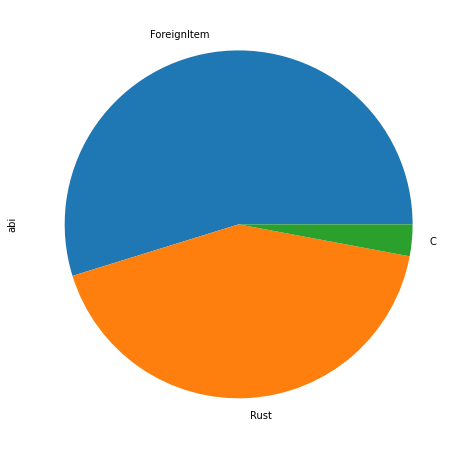

In [20]:
# Frequency of abi DEFINITIONS - top 250
values = unsafe_function_definitions_250.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions_250) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions_250))
values.plot.pie()
del values

Rust           1093
ForeignItem     908
C                78
Name: abi, dtype: int64
Rust           52.573353
ForeignItem    43.674844
C               3.751804
Name: abi, dtype: float64
Unsafe function definitions: 2079


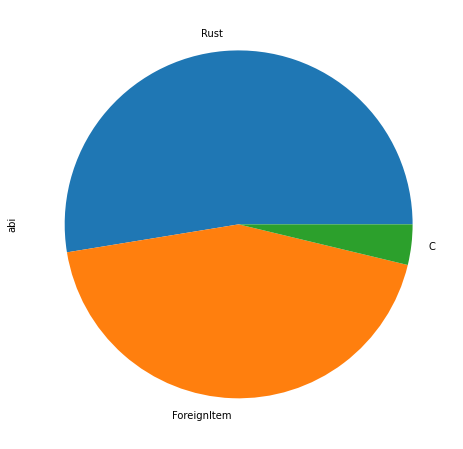

In [21]:
# Frequency of abi DEFINITIONS - top 500
values = unsafe_function_definitions_500.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions_500) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions_500))
values.plot.pie()
del values

Rust           5227
ForeignItem    4223
C               141
sysv64            2
Name: abi, dtype: int64
Rust           54.487647
ForeignItem    44.021682
C               1.469822
sysv64          0.020849
Name: abi, dtype: float64
Unsafe function definitions: 9593


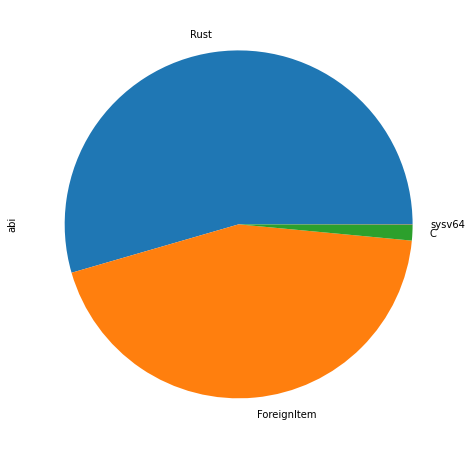

In [22]:
# Frequency of abi DEFINITIONS - top 1000
values = unsafe_function_definitions_1000.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions_1000) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions_1000))
values.plot.pie()
del values

ForeignItem    52604
Rust           42094
C               3040
sysv64             2
system             2
Name: abi, dtype: int64
ForeignItem    53.819238
Rust           43.066440
C               3.110229
sysv64          0.002046
system          0.002046
Name: abi, dtype: float64
Unsafe function definitions: 97742


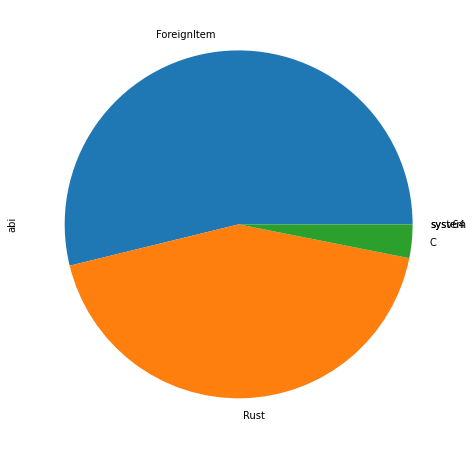

In [23]:
# Frequency of abi DEFINITIONS - ALL
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

In [24]:
# Which crates define unsafe Rust functions? - top 250
def_unsafe_rust_funcs_250 = unsafe_function_definitions_250[
    unsafe_function_definitions_250.abi == "Rust"
]

values = def_unsafe_rust_funcs_250.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 52
Names and counts of 20 crates with most defined unsafe Rust functions:

openssl             80
cloudabi            66
tokio               54
wasi                45
nix                 37
bytes               34
hashbrown           34
parking_lot         27
memchr              26
hyper               25
lock_api            23
parking_lot_core    21
encoding_rs         20
rand_chacha         18
dtoa                14
anyhow              11
httparse            11
backtrace            9
ryu                  9
smallvec             9
Name: crate, dtype: int64


In [25]:
# Which crates define unsafe Rust functions? - top 500
def_unsafe_rust_funcs_500 = unsafe_function_definitions_500[
    unsafe_function_definitions_500.abi == "Rust"
]

values = def_unsafe_rust_funcs_500.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 87
Names and counts of 20 crates with most defined unsafe Rust functions:

git2                108
openssl              80
blake2b_simd         77
cloudabi             66
tokio                54
wasi                 45
tendril              40
widestring           38
nix                  37
hashbrown            34
bytes                34
ascii                33
parking_lot          27
memchr               26
hyper                25
lock_api             23
parking_lot_core     21
encoding_rs          20
rand_chacha          18
bumpalo              16
Name: crate, dtype: int64


In [26]:
# Which crates define unsafe Rust functions? - top 1000
def_unsafe_rust_funcs_1000 = unsafe_function_definitions_1000[
    unsafe_function_definitions_1000.abi == "Rust"
]

values = def_unsafe_rust_funcs_1000.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 152
Names and counts of 20 crates with most defined unsafe Rust functions:

gleam             2095
glib               841
nalgebra           220
stdweb             157
alga               153
git2               108
ndarray             84
dlmalloc            80
openssl             80
blake2b_simd        77
cloudabi            66
tokio               54
wasi                45
tendril             40
widestring          38
nix                 37
winit               35
matrixmultiply      35
bytes               34
hashbrown           34
Name: crate, dtype: int64


In [27]:
# Which crates define unsafe Rust functions? - ALL
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

values = def_unsafe_rust_funcs.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 922
Names and counts of 20 crates with most defined unsafe Rust functions:

gtk            4424
gio            2836
lapacke        2205
gleam          2095
sparkle        1789
glium          1774
glow           1566
gstreamer      1324
stm32f30x      1249
lapack         1103
glib            841
webkit2gtk      828
mallumo_gls     825
js_sys          803
gc              717
gfx_gl          703
gl              695
ash             692
atk             679
pango           595
Name: crate, dtype: int64


In [28]:
# Which crates define C functions? - top 250
def_c_funcs_250 = unsafe_function_definitions_250[
    unsafe_function_definitions_250.abi == "C"
]

values = def_c_funcs_250.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 4
Names and counts:

libc         27
openssl      18
backtrace     1
ring          1
Name: crate, dtype: int64


In [29]:
# Which crates define C functions? - top 500
def_c_funcs_500 = unsafe_function_definitions_500[
    unsafe_function_definitions_500.abi == "C"
]

values = def_c_funcs_500.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 5
Names and counts:

miniz_oxide_c_api    31
libc                 27
openssl              18
backtrace             1
ring                  1
Name: crate, dtype: int64


In [30]:
# Which crates define C functions? - top 1000
def_c_funcs_1000 = unsafe_function_definitions_1000[
    unsafe_function_definitions_1000.abi == "C"
]

values = def_c_funcs_1000.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 12
Names and counts:

glib                 39
miniz_oxide_c_api    31
libc                 27
openssl              18
block                15
winit                 4
onig                  2
backtrace             1
secp256k1             1
ring                  1
zmq                   1
rusqlite              1
Name: crate, dtype: int64


In [31]:
# Which crates define C functions? - ALL
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]

values = def_c_funcs.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 68
Names and counts:

gtk                    1330
gio                     310
webkit2gtk              134
gstreamer               120
wasm_bindgen             96
pyo3                     96
cxx                      92
lodepng                  77
gstreamer_base           74
gmp_mpfr_sys             68
                       ... 
wasmer_clif_backend       1
argv                      1
ring                      1
findshlibs                1
libarchive                1
xkbcommon                 1
nettle                    1
async_timer               1
backtrace                 1
harfbuzz                  1
Name: crate, Length: 68, dtype: int64


In [32]:
# Which crates define Foreign Items? - top 250
def_fi_funcs_250 = unsafe_function_definitions_250[
    unsafe_function_definitions_250.abi == "ForeignItem"
]

values = def_fi_funcs_250.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 5
Names and counts of 20 crates with most defined Foreign Items:

libc         704
ring          74
cloudabi      49
wasi          45
backtrace      4
Name: crate, dtype: int64


In [33]:
# Which crates define Foreign Items? - top 500
def_fi_funcs_500 = unsafe_function_definitions_500[
    unsafe_function_definitions_500.abi == "ForeignItem"
]

values = def_fi_funcs_500.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 11
Names and counts of 20 crates with most defined Foreign Items:

libc          704
ring           74
cloudabi       49
wasi           45
termios        13
xattr           8
libloading      5
backtrace       4
termion         3
errno           2
term_size       1
Name: crate, dtype: int64


In [34]:
# Which crates define Foreign Items? - top 1000
def_fi_funcs_1000 = unsafe_function_definitions_1000[
    unsafe_function_definitions_1000.abi == "ForeignItem"
]

values = def_fi_funcs_1000.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 24
Names and counts of 20 crates with most defined Foreign Items:

x11               1626
stdweb             940
libc               704
xcb                482
onig_sys           146
ring                74
objc                54
cloudabi            49
wasi                45
secp256k1           27
cgl                 26
termios             13
xattr                8
libloading           5
shared_library       4
backtrace            4
psm                  4
termion              3
users                2
errno                2
Name: crate, dtype: int64


In [35]:
# Which crates define Foreign Items? - ALL
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]

values = def_fi_funcs.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 291
Names and counts of 20 crates with most defined Foreign Items:

gtk_sys                4144
lapacke_sys            2205
libxml                 1945
gio_sys                1865
rust_hawktracer_sys    1700
x11                    1626
glib_sys               1494
glib_2_0_sys           1477
gstreamer_sys          1457
ffmpeg_sys             1327
alsa_sys               1281
sdl2_sys               1192
lapack_sys             1103
nettle_sys              972
stdweb                  940
libsodium_sys           863
libsodium_ffi           796
python3_sys             738
openssl_sys             733
pyo3                    720
Name: crate, dtype: int64


C       1664
Rust     913
Name: abi, dtype: int64
C       64.571207
Rust    35.428793
Name: abi, dtype: float64
Unsafe calls: 2577


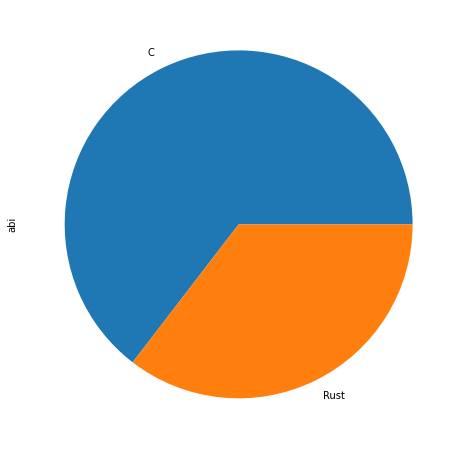

In [36]:
# Frequency of abi CALLS - top 250
unsafe_const_calls_250 = const_calls_250[
    const_calls_250.unsafety == "Unsafe"
]
values = unsafe_const_calls_250.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls_250) * 100)
print("Unsafe calls:", len(unsafe_const_calls_250))
values.plot.pie()
del values

Rust    2340
C       1690
Name: abi, dtype: int64
Rust    58.064516
C       41.935484
Name: abi, dtype: float64
Unsafe calls: 4030


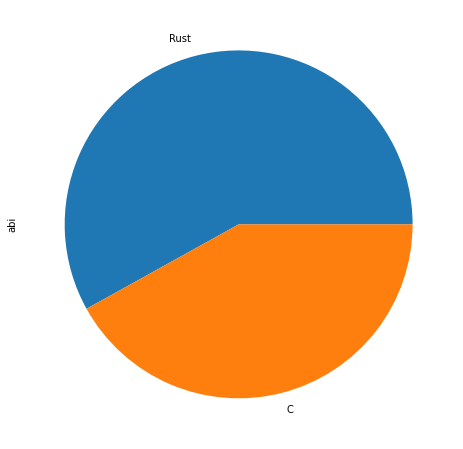

In [37]:
# Frequency of abi CALLS - top 500
unsafe_const_calls_500 = const_calls_500[
    const_calls_500.unsafety == "Unsafe"
]
values = unsafe_const_calls_500.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls_500) * 100)
print("Unsafe calls:", len(unsafe_const_calls_500))
values.plot.pie()
del values

Rust      9711
C         3236
sysv64       2
Name: abi, dtype: int64
Rust      74.994208
C         24.990347
sysv64     0.015445
Name: abi, dtype: float64
Unsafe calls: 12949


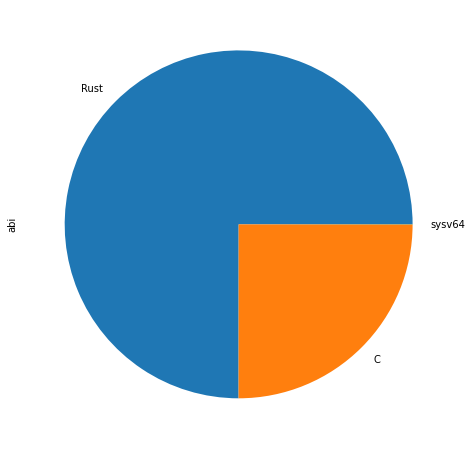

In [38]:
# Frequency of abi CALLS - top 1000
unsafe_const_calls_1000 = const_calls_1000[
    const_calls_1000.unsafety == "Unsafe"
]
values = unsafe_const_calls_1000.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls_1000) * 100)
print("Unsafe calls:", len(unsafe_const_calls_1000))
values.plot.pie()
del values

Rust                  72644
C                     29301
rust-intrinsic        18032
platform-intrinsic     3018
system                  272
sysv64                    2
Name: abi, dtype: int64
Rust                  58.931280
C                     23.769966
rust-intrinsic        14.628171
platform-intrinsic     2.448304
system                 0.220656
sysv64                 0.001622
Name: abi, dtype: float64
Unsafe calls: 123269


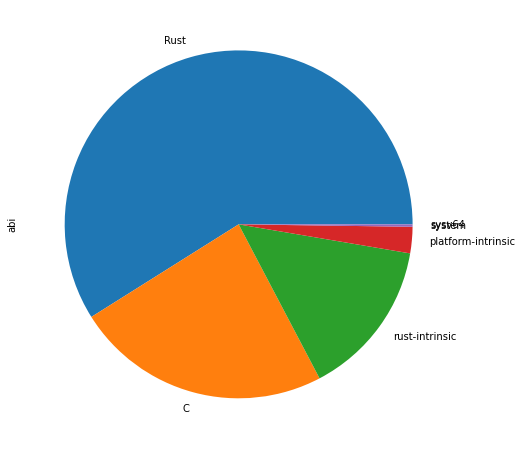

In [39]:
# Frequency of abi CALLS - ALL
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
values = unsafe_const_calls.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls) * 100)
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()
del values

In [40]:
# Which crates call unsafe Rust functions? - top 250
calls_unsafe_rust_funcs_250 = unsafe_const_calls_250[
    unsafe_const_calls_250.abi == "Rust"
]

values = calls_unsafe_rust_funcs_250.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs_250 = calls_unsafe_rust_funcs_250[
    calls_unsafe_rust_funcs_250.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs_250.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 42
Names and counts of 20 crates with most unsafe Rust function calls:

hashbrown           144
nix                 127
lock_api             83
bytes                79
socket2              53
encoding_rs          48
tokio                46
arrayvec             36
parking_lot_core     31
smallvec             29
openssl              25
bstr                 20
rand_chacha          18
http                 18
httparse             18
memchr               18
thread_local         12
byteorder            11
syn                  11
parking_lot           7
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 42
Names and counts of 20 crates with most user-written unsafe Rust function calls:

hashbrown           144
nix                 127
lock_api             83
bytes                79
socket2              53
encoding_rs          48
tokio                46
arrayvec             36
parking_lo

In [41]:
# Which crates call unsafe Rust functions? - top 500
calls_unsafe_rust_funcs_500 = unsafe_const_calls_500[
    unsafe_const_calls_500.abi == "Rust"
]

values = calls_unsafe_rust_funcs_500.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs_500 = calls_unsafe_rust_funcs_500[
    calls_unsafe_rust_funcs_500.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs_500.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 71
Names and counts of 20 crates with most unsafe Rust function calls:

libloading          551
git2                318
combine             210
hashbrown           144
nix                 127
image                96
lock_api             83
bytes                79
tendril              56
socket2              53
encoding_rs          48
tokio                46
arrayvec             36
parking_lot_core     31
smallvec             29
openssl              25
curl                 23
memmap               20
bstr                 20
json                 19
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 71
Names and counts of 20 crates with most user-written unsafe Rust function calls:

libloading          551
git2                318
combine             210
hashbrown           144
nix                 127
image                96
lock_api             83
bytes                79
tendril   

In [42]:
# Which crates call unsafe Rust functions? - 1000
calls_unsafe_rust_funcs_1000 = unsafe_const_calls_1000[
    unsafe_const_calls_1000.abi == "Rust"
]

values = calls_unsafe_rust_funcs_1000.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs_1000 = calls_unsafe_rust_funcs_1000[
    calls_unsafe_rust_funcs_1000.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs_1000.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 120
Names and counts of 20 crates with most unsafe Rust function calls:

glib           4769
nalgebra       1032
libloading      551
gleam           399
stdweb          359
git2            318
combine         210
ndarray         176
hashbrown       144
nix             127
objc            115
image            96
rental           96
lock_api         83
bytes            79
dbus             58
tendril          56
socket2          53
encoding_rs      48
tokio            46
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 120
Names and counts of 20 crates with most user-written unsafe Rust function calls:

glib           4769
nalgebra       1032
libloading      551
gleam           399
stdweb          359
git2            318
combine         210
ndarray         176
hashbrown       144
nix             127
objc            115
image            96
rental           96
lock_api         83


In [43]:
# Which crates call unsafe Rust functions? - ALL
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]

values = calls_unsafe_rust_funcs.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs.crate_defsite.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 609
Names and counts of 20 crates with most unsafe Rust function calls:

core                44248
glib                 4769
std                  1745
alloc                1361
nalgebra             1032
al_sys                768
gstreamer             742
pyo3                  695
js_sys                692
sample                625
wasm_bindgen          605
glium                 561
libloading            551
packed_simd           462
sparkle               413
gleam                 399
stdweb                359
git2                  318
unic_langid_impl      310
gfx_gl                256
Name: crate_defsite, dtype: int64
Number of crates that call unsafe Rust functions from user-written blocks:	 609
Names and counts of 20 crates with most user-written unsafe Rust function calls:

core                36353
glib                 4769
std                  1745
alloc                1361
nalgebra             1032
al_sys                768
gstr

In [44]:
# Which crates call C functions? - top 250
calls_c_funcs_250 = unsafe_const_calls_250[
    unsafe_const_calls_250.abi == "C"
]

values = calls_c_funcs_250.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 3
Names and counts of 20 crates with most C function calls:

libc         1606
ring           55
backtrace       3
Name: crate_defsite, dtype: int64


In [45]:
# Which crates call C functions? - top 500
calls_c_funcs_500 = unsafe_const_calls_500[
    unsafe_const_calls_500.abi == "C"
]

values = calls_c_funcs_500.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 8
Names and counts of 20 crates with most C function calls:

libc          1606
ring            55
termios         13
libloading       5
errno            3
backtrace        3
termion          3
xattr            2
Name: crate_defsite, dtype: int64


In [46]:
# Which crates call C functions? - top 1000
calls_c_funcs_1000 = unsafe_const_calls_1000[
    unsafe_const_calls_1000.abi == "C"
]

values = calls_c_funcs_1000.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 18
Names and counts of 20 crates with most C function calls:

libc              1606
stdweb             937
xcb                429
objc               101
ring                55
onig_sys            33
secp256k1           28
termios             13
x11                 12
libloading           5
termion              3
backtrace            3
errno                3
xattr                2
users                2
shared_library       2
clear_on_drop        1
block                1
Name: crate_defsite, dtype: int64


In [47]:
# Which crates call C functions? - ALL
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

values = calls_c_funcs.crate_defsite.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 238
Names and counts of 20 crates with most C function calls:

gtk_sys               3356
gsl_sys               2216
libc                  1606
glib_sys              1592
gstreamer_sys         1548
gio_sys               1369
gobject_sys            955
stdweb                 937
openssl_sys            750
libgit2_sys            544
gdk_sys                479
gmp_mpfr_sys           478
pyo3                   439
alsa_sys               429
xcb                    429
ncurses                399
csfml_graphics_sys     397
sdl2_sys               395
webkit2gtk_sys         378
libpulse_sys           363
Name: crate_defsite, dtype: int64


In [48]:
# SIMD const calls total - top 250
simd_functions_250 = set([
    x
    for x in const_calls_250.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_250[
    const_calls_250.def_path.isin(simd_functions_250)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 0
Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
[]


In [49]:
# SIMD const calls total - top 500
simd_functions_500 = set([
    x
    for x in const_calls_500.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_500[
    const_calls_500.def_path.isin(simd_functions_500)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 0
Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
[]


In [50]:
# SIMD const calls total - top 1000
simd_functions_1000 = set([
    x
    for x in const_calls_1000.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_1000[
    const_calls_1000.def_path.isin(simd_functions_1000)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 0
Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
[]


In [51]:
# SIMD const calls total
simd_functions = set([
    x
    for x in const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls[
    const_calls.def_path.isin(simd_functions)
]

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, simd_crates

Total number of SIMD calls:	 0
Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
[]


In [52]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [53]:
# Unchecked functions - top 250
print("unchecked_function_names_250:\t", len(unchecked_function_names_250))

const_unchecked_calls_250 = const_calls_250[
    const_calls_250.def_path.isin(unchecked_function_names_250)
]
unchecked_calls_250 = unsafe_block_const_calls_250[
    unsafe_block_const_calls_250.def_path.isin(unchecked_function_names_250)
]
assert(len(const_unchecked_calls_250) == len(unchecked_calls_250))

print("Calls to unchecked functions:\t", len(unchecked_calls_250))
#print("Percentage:\t\t\t", len(unchecked_calls_250)/len(unsafe_calls_250)*100)

# Top unchecked() calling code
values = unchecked_calls_250 [['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/250*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls_250.unsafe_scope.unique())/len(unsafe_block_const_calls_250.unsafe_scope.unique())*100
)
del values

unchecked_function_names_250:	 66
Calls to unchecked functions:	 42
Number of crates:		 9
Percentage:			 3.5999999999999996
(http, 3b69d46729b6a1c5)           14
(arrayvec, 8b3935291d8f38d1)        6
(bstr, e4470b7aafa9657c)            6
(actix_utils, b536c544022d3c9d)     6
(h2, 5043567644ccd6c3)              4
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 1.3680781758957654


In [54]:
# Unchecked functions - top 500
print("unchecked_function_names_500:\t", len(unchecked_function_names_500))

const_unchecked_calls_500 = const_calls_500[
    const_calls_500.def_path.isin(unchecked_function_names_500)
]
unchecked_calls_500 = unsafe_block_const_calls_500[
    unsafe_block_const_calls_500.def_path.isin(unchecked_function_names_500)
]
assert(len(const_unchecked_calls_500) == len(unchecked_calls_500))

print("Calls to unchecked functions:\t", len(unchecked_calls_500))
#print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/500*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls_500.unsafe_scope.unique())/len(unsafe_block_const_calls_500.unsafe_scope.unique())*100
)
del values

unchecked_function_names_500:	 169
Calls to unchecked functions:	 89
Number of crates:		 17
Percentage:			 3.4000000000000004
(json, ded027994e328267)         14
(http, 3b69d46729b6a1c5)         14
(pest, e0b79869a7275259)          8
(criterion, 8c5606e6f0d134c)      7
(bytecount, 26bfc892c82d25c9)     6
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 1.7215727948990436


In [55]:
# Unchecked functions - top 1000
print("unchecked_function_names_1000:\t", len(unchecked_function_names_1000))

const_unchecked_calls_1000 = const_calls_1000[
    const_calls_1000.def_path.isin(unchecked_function_names_1000)
]
unchecked_calls_1000 = unsafe_block_const_calls_1000[
    unsafe_block_const_calls_1000.def_path.isin(unchecked_function_names_1000)
]
assert(len(const_unchecked_calls_1000) == len(unchecked_calls_1000))

print("Calls to unchecked functions:\t", len(unchecked_calls_1000))
#print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/1000*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls_1000.unsafe_scope.unique())/len(unsafe_block_const_calls_1000.unsafe_scope.unique())*100
)
del values

unchecked_function_names_1000:	 971
Calls to unchecked functions:	 1128
Number of crates:		 28
Percentage:			 2.8000000000000003
(nalgebra, a113c0e4a3911470)    837
(dbus, 5cba9142055d8dfd)         48
(xcb, 3cb77ef3fe226d8)           44
(stdweb, 4cdd5adf39190f1)        36
(winit, 862dcffb234e8085)        27
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 2.3241618931355057


In [56]:
# Unchecked functions - ALL
print("unchecked_function_names:\t", len(unchecked_function_names))

const_unchecked_calls = const_calls[
    const_calls.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))

print("Calls to unchecked functions:\t", len(unchecked_calls))
print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names:	 2987
Calls to unchecked functions:	 2112
Percentage:			 0.14028701714065567
Number of crates:		 105
Percentage:			 2.278645833333333
(nalgebra, a113c0e4a3911470)       837
(packed_simd, 542d705a24f3b9de)    414
(domain, db5e81a44e0e0cbe)          61
(dbus, 5cba9142055d8dfd)            48
(xcb, 3cb77ef3fe226d8)              44
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 1.089091771222989


In [57]:
# Top called unchecked() code - 250
values = unchecked_calls_250[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/250*100)
print(values[:5])
del values

Number of crates:	 12
Percentage: 4.8
http[f3e7]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]          14
arrayvec[a8ec]::{{impl}}[1]::get_unchecked_ptr[0]                      5
slab[93b6]::{{impl}}[1]::get_unchecked_mut[0]                          5
bstr[ba21]::ext_slice[0]::ByteSlice[0]::to_str_unchecked[0]            4
h2[815f]::hpack[0]::header[0]::{{impl}}[4]::from_utf8_unchecked[0]     4
dtype: int64


In [58]:
# Top called unchecked() code - 500
values = unchecked_calls_500[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/500*100)
print(values[:5])
del values

Number of crates:	 26
Percentage: 5.2
http[f3e7]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]                              14
json[ceec]::number[0]::{{impl}}[0]::from_parts_unchecked[0]                               14
criterion[2010]::stats[0]::univariate[0]::percentiles[0]::{{impl}}[0]::at_unchecked[0]     7
bytecount[9944]::integer_simd[0]::usize_load_unchecked[0]                                  6
pest[8329]::position[0]::{{impl}}[0]::new_unchecked[0]                                     6
dtype: int64


In [59]:
# Top called unchecked() code - 1000
values = unchecked_calls_1000[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/1000*100)
print(values[:5])
del values

Number of crates:	 106
Percentage: 10.6
nalgebra[ac71]::base[0]::indexing[0]::{{impl}}[8]::get_unchecked_mut[0]    512
nalgebra[ac71]::base[0]::indexing[0]::{{impl}}[8]::get_unchecked[0]        148
nalgebra[ac71]::base[0]::matrix[0]::{{impl}}[7]::vget_unchecked[0]          40
nalgebra[ac71]::base[0]::matrix[0]::{{impl}}[8]::vget_unchecked_mut[0]      37
dbus[e68f]::strings[0]::{{impl}}[10]::from_slice_unchecked[0]               34
dtype: int64


In [60]:
# Top called unchecked() code - ALL
values = unchecked_calls[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])
del values

Number of crates:	 732
Percentage: 15.885416666666666
nalgebra[ac71]::base[0]::indexing[0]::{{impl}}[8]::get_unchecked_mut[0]    512
nalgebra[ac71]::base[0]::indexing[0]::{{impl}}[8]::get_unchecked[0]        148
nalgebra[ac71]::base[0]::matrix[0]::{{impl}}[7]::vget_unchecked[0]          40
nalgebra[ac71]::base[0]::matrix[0]::{{impl}}[8]::vget_unchecked_mut[0]      37
dbus[e68f]::strings[0]::{{impl}}[10]::from_slice_unchecked[0]               34
dtype: int64


In [61]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))

const_unguarded_calls = const_calls[
    const_calls.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print("Calls to unguarded functions:\t", len(unguarded_calls))
print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])

print("Percentage of unsafe blocks with an unguarded function call:\t",
     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unguarded_function_names:	 2
Calls to unguarded functions:	 1
Percentage:			 6.642377705523469e-05


AttributeError: 'tuple' object has no attribute 'value_counts'

In [62]:
### Filter by user-written unsafe code - 250
user_written_unsafe_const_calls_250 = const_calls_250[
    const_calls_250.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust_250 = user_written_unsafe_const_calls_250[
    user_written_unsafe_const_calls_250.abi == "Rust"
]
user_written_unsafe_const_calls_fi_250 = user_written_unsafe_const_calls_250[
    user_written_unsafe_const_calls_250.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c_250 = user_written_unsafe_const_calls_250[
    user_written_unsafe_const_calls_250.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust_250 = set([
    x
    for x in user_written_unsafe_const_calls_rust_250.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [63]:
### Filter by user-written unsafe code - 500
user_written_unsafe_const_calls_500 = const_calls_500[
    const_calls_500.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust_500 = user_written_unsafe_const_calls_500[
    user_written_unsafe_const_calls_500.abi == "Rust"
]
user_written_unsafe_const_calls_fi_500 = user_written_unsafe_const_calls_500[
    user_written_unsafe_const_calls_500.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c_500 = user_written_unsafe_const_calls_500[
    user_written_unsafe_const_calls_500.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust_500 = set([
    x
    for x in user_written_unsafe_const_calls_rust_500.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [64]:
### Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls[
    const_calls.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [65]:
### Filter by user-written unsafe code - 1000
user_written_unsafe_const_calls_1000 = const_calls_1000[
    const_calls_1000.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust_1000 = user_written_unsafe_const_calls_1000[
    user_written_unsafe_const_calls_1000.abi == "Rust"
]
user_written_unsafe_const_calls_fi_1000 = user_written_unsafe_const_calls_1000[
    user_written_unsafe_const_calls_1000.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c_1000 = user_written_unsafe_const_calls_1000[
    user_written_unsafe_const_calls_1000.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust_1000 = set([
    x
    for x in user_written_unsafe_const_calls_rust_1000.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [66]:
# Performance-motivated Rust calls
# 250
perf_mot_unsafe_rust_calls_250 = user_written_unsafe_const_calls_rust_250[
    user_written_unsafe_const_calls_rust_250.def_path.isin(perf_mot_unsafe_rust_250)
]
pmu_rust_calls_250 = perf_mot_unsafe_rust_calls_250[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
# 500
perf_mot_unsafe_rust_calls_500 = user_written_unsafe_const_calls_rust_500[
    user_written_unsafe_const_calls_rust_500.def_path.isin(perf_mot_unsafe_rust_500)
]
pmu_rust_calls_500 = perf_mot_unsafe_rust_calls_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
# 1000
perf_mot_unsafe_rust_calls_1000 = user_written_unsafe_const_calls_rust_1000[
    user_written_unsafe_const_calls_rust_1000.def_path.isin(perf_mot_unsafe_rust_1000)
]
pmu_rust_calls_1000 = perf_mot_unsafe_rust_calls_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
# ALL
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]
pmu_rust_calls = perf_mot_unsafe_rust_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

# ForeignItem calls
fi_calls_250 = user_written_unsafe_const_calls_fi_250[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
fi_calls_500 = user_written_unsafe_const_calls_fi_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
fi_calls_1000 = user_written_unsafe_const_calls_fi_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
fi_calls = user_written_unsafe_const_calls_fi[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

# C calls
c_calls_250 = user_written_unsafe_const_calls_c_250[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
c_calls_500 = user_written_unsafe_const_calls_c_500[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
c_calls_1000 = user_written_unsafe_const_calls_c_1000[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
c_calls = user_written_unsafe_const_calls_c[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

len_all = len(perf_mot_unsafe_rust_calls) + len(user_written_unsafe_const_calls_fi) + len(user_written_unsafe_const_calls_c)
len_all_250 = len(perf_mot_unsafe_rust_calls_250) + len(user_written_unsafe_const_calls_fi_250) + len(user_written_unsafe_const_calls_c_250)
len_all_500 = len(perf_mot_unsafe_rust_calls_500) + len(user_written_unsafe_const_calls_fi_500) + len(user_written_unsafe_const_calls_c_500)
len_all_1000 = len(perf_mot_unsafe_rust_calls_1000) + len(user_written_unsafe_const_calls_fi_1000) + len(user_written_unsafe_const_calls_c_1000)
#len_all_1000 = len(perf_mot_unsafe_rust_calls_1000) + len(user_written_unsafe_const_calls_fi_1000 + len(user_written_unsafe_const_calls_c_1000)

In [67]:
# 250
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls_250))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls_250)/len(user_written_unsafe_const_calls_250)*100)
print("Number of crates:\t", len(pmu_rust_calls_250.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls_250.value_counts())/250*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi_250))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi_250)/len(user_written_unsafe_const_calls_250)*100)
print("Number of crates:\t", len(fi_calls_250.value_counts()))
print("Percentage:\t\t", len(fi_calls_250.value_counts())/250*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c_250))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c_250)/len(user_written_unsafe_const_calls_250)*100)
print("Number of crates:\t", len(c_calls_250.value_counts()))
print("Percentage:\t\t", len(c_calls_250.value_counts())/250*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all_250)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls_250))
print("Percent user-written PMU out of const calls:\t\t", len_all_250/len(user_written_unsafe_const_calls_250)*100)

block_frames = [pmu_rust_calls_250, fi_calls_250, c_calls_250]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/250*100)
del len_all_250, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 70
Percent out of unsafe const calls:		 1.1711560983771123
Number of crates:	 17
Percentage:		 6.800000000000001

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 1678
Percent out of unsafe const calls:	 28.07428475823992
Number of crates:	 217
Percentage:		 86.8

Total number of (user-written) PMU calls:		 1748
Out of total number user-written unsafe const calls:	 5977
Percent user-written PMU out of const calls:		 29.245440856617034
Number of crates:	 234
Percentage:		 93.60000000000001


In [68]:
# 500
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls_500))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls_500)/len(user_written_unsafe_const_calls_500)*100)
print("Number of crates:\t", len(pmu_rust_calls_500.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls_500.value_counts())/500*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi_500))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi_500)/len(user_written_unsafe_const_calls_500)*100)
print("Number of crates:\t", len(fi_calls_500.value_counts()))
print("Percentage:\t\t", len(fi_calls_500.value_counts())/500*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c_500))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c_500)/len(user_written_unsafe_const_calls_500)*100)
print("Number of crates:\t", len(c_calls_500.value_counts()))
print("Percentage:\t\t", len(c_calls_500.value_counts())/500*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all_500)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls_500))
print("Percent user-written PMU out of const calls:\t\t", len_all_500/len(user_written_unsafe_const_calls_500)*100)

block_frames = [pmu_rust_calls_500, fi_calls_500, c_calls_500]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/500*100)
del len_all_500, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 126
Percent out of unsafe const calls:		 1.2673506336753169
Number of crates:	 25
Percentage:		 5.0

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 1704
Percent out of unsafe const calls:	 17.139408569704283
Number of crates:	 221
Percentage:		 44.2

Total number of (user-written) PMU calls:		 1830
Out of total number user-written unsafe const calls:	 9942
Percent user-written PMU out of const calls:		 18.406759203379604
Number of crates:	 246
Percentage:		 49.2


In [69]:
# 1000
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls_1000))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls_1000)/len(user_written_unsafe_const_calls_1000)*100)
print("Number of crates:\t", len(pmu_rust_calls_1000.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls_1000.value_counts())/1000*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi_1000))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi_1000)/len(user_written_unsafe_const_calls_1000)*100)
print("Number of crates:\t", len(fi_calls_1000.value_counts()))
print("Percentage:\t\t", len(fi_calls_1000.value_counts())/1000*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c_1000))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c_1000)/len(user_written_unsafe_const_calls_1000)*100)
print("Number of crates:\t", len(c_calls_1000.value_counts()))
print("Percentage:\t\t", len(c_calls_1000.value_counts())/1000*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all_1000)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls_1000))
print("Percent user-written PMU out of const calls:\t\t", len_all_1000/len(user_written_unsafe_const_calls_1000)*100)

block_frames = [pmu_rust_calls_1000, fi_calls_1000, c_calls_1000]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/1000*100)
del len_all_1000, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 1442
Percent out of unsafe const calls:		 3.3761794385521293
Number of crates:	 39
Percentage:		 3.9

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 3250
Percent out of unsafe const calls:	 7.609280981480181
Number of crates:	 231
Percentage:		 23.1

Total number of (user-written) PMU calls:		 4692
Out of total number user-written unsafe const calls:	 42711
Percent user-written PMU out of const calls:		 10.98546042003231
Number of crates:	 267
Percentage:		 26.700000000000003


In [70]:
# ALL
print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(user_written_unsafe_const_calls)*100)

block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 9174
Percent out of unsafe const calls:		 3.757141394491655
Number of crates:	 514
Percentage:		 11.15451388888889

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 29315
Percent out of unsafe const calls:	 12.005733592710147
Number of crates:	 421
Percentage:		 9.136284722222223

Total number of (user-written) PMU calls:		 38489
Out of total number user-written unsafe const calls:	 244175
Percent user-written PMU out of const calls:		 15.762874987201803
Number of crates:	 860
Percentage:		 18.663194444444446


In [71]:
# 250
len_all = len(def_c_funcs_250) + len(def_fi_funcs_250)

print("Total number of ForeignItem definitions:", len(def_fi_funcs_250))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs_250)/len(unsafe_function_definitions_250)*100)
print("Number of crates:\t", len(def_fi_funcs_250.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs_250.crate.value_counts())/250*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs_250))
print("Percent out of unsafe definitions:\t", len(def_c_funcs_250)/len(unsafe_function_definitions_250)*100)
print("Number of crates:\t", len(def_c_funcs_250.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs_250.crate.value_counts())/250*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions_250))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions_250)*100)

block_frames = [def_c_funcs_250, def_fi_funcs_250]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/250*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 876
Percent out of unsafe definitions:	 54.78424015009381
Number of crates:	 5
Percentage:		 2.0

Total number of C definitions:		 47
Percent out of unsafe definitions:	 2.9393370856785492
Number of crates:	 4
Percentage:		 1.6

Total number of PMU definitions:	 923
Total number of unsafe function defs:	 1599
Percent PMU out of unsafe definitions:	 57.72357723577236
Number of crates:	 6
Percentage:		 2.4


In [72]:
# 500
len_all = len(def_c_funcs_500) + len(def_fi_funcs_500)

print("Total number of ForeignItem definitions:", len(def_fi_funcs_500))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs_500)/len(unsafe_function_definitions_500)*100)
print("Number of crates:\t", len(def_fi_funcs_500.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs_500.crate.value_counts())/500*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs_500))
print("Percent out of unsafe definitions:\t", len(def_c_funcs_500)/len(unsafe_function_definitions_500)*100)
print("Number of crates:\t", len(def_c_funcs_500.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs_500.crate.value_counts())/500*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions_500))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions_500)*100)

block_frames = [def_c_funcs_500, def_fi_funcs_500]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/500*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 908
Percent out of unsafe definitions:	 43.67484367484368
Number of crates:	 11
Percentage:		 2.1999999999999997

Total number of C definitions:		 78
Percent out of unsafe definitions:	 3.751803751803752
Number of crates:	 5
Percentage:		 1.0

Total number of PMU definitions:	 986
Total number of unsafe function defs:	 2079
Percent PMU out of unsafe definitions:	 47.42664742664743
Number of crates:	 13
Percentage:		 2.6


In [73]:
# 1000
len_all = len(def_c_funcs_1000) + len(def_fi_funcs_1000)

print("Total number of ForeignItem definitions:", len(def_fi_funcs_1000))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs_1000)/len(unsafe_function_definitions_1000)*100)
print("Number of crates:\t", len(def_fi_funcs_1000.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs_1000.crate.value_counts())/1000*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs_1000))
print("Percent out of unsafe definitions:\t", len(def_c_funcs_1000)/len(unsafe_function_definitions_1000)*100)
print("Number of crates:\t", len(def_c_funcs_1000.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs_1000.crate.value_counts())/1000*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions_1000))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions_1000)*100)

block_frames = [def_c_funcs_1000, def_fi_funcs_1000]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/1000*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 4223
Percent out of unsafe definitions:	 44.021682476806006
Number of crates:	 24
Percentage:		 2.4

Total number of C definitions:		 141
Percent out of unsafe definitions:	 1.4698217450224123
Number of crates:	 12
Percentage:		 1.2

Total number of PMU definitions:	 4364
Total number of unsafe function defs:	 9593
Percent PMU out of unsafe definitions:	 45.491504221828414
Number of crates:	 31
Percentage:		 3.1


In [74]:
# ALL
len_all = len(def_c_funcs) + len(def_fi_funcs)

print("Total number of ForeignItem definitions:", len(def_fi_funcs))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_fi_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs.crate.value_counts())/len(selected_builds)*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs))
print("Percent out of unsafe definitions:\t", len(def_c_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_c_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs.crate.value_counts())/len(selected_builds)*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions)*100)

block_frames = [def_c_funcs, def_fi_funcs]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 52604
Percent out of unsafe definitions:	 53.81923840314297
Number of crates:	 291
Percentage:		 6.315104166666667

Total number of C definitions:		 3040
Percent out of unsafe definitions:	 3.110228970145894
Number of crates:	 68
Percentage:		 1.4756944444444444

Total number of PMU definitions:	 55644
Total number of unsafe function defs:	 97742
Percent PMU out of unsafe definitions:	 56.929467373288865
Number of crates:	 339
Percentage:		 7.356770833333333


In [75]:
# Total PMU code - top 250
block_frames = [pmu_rust_calls_250, c_calls_250, fi_calls_250, def_c_funcs_250, def_fi_funcs_250] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/250*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 234
Percentage:		 93.60000000000001

List of 20 crates with the most performance-motivated unsafe code:
(nix, 678cd5ce34476c9a)                 361
(rppal, ffa4b1889edf67fd)                75
(ring, 40eb50384ac3d18e)                 57
(vmm_sys_util, 3d5ead8aec3ca7b3)         47
(cicada, 35ea477f2c491a29)               40
(cicada, a099a20c369f3e98)               38
(pnet_datalink, 9173d425e8aaab78)        34
(xcb, 3cb77ef3fe226d8)                   32
(parity_daemonize, 71394dca4dc049f0)     30
(gaol, 114cccb67db990a0)                 30
(ipc_channel, 34e56c505fb54cde)          28
(unix_socket, 2afb9325604aa852)          27
(unix_socket, 7acbaaf995f79bfb)          25
(socket2, 28347540f0e15d0)               24
(palaver, 89cb2b6034f6246)               22
(bigint, 50f14a752d4b1bb7)               20
(subprocess, 73eac1743f6f6b21)           19
(openat, 20f793f1c5233953)               18
(mio_uds, 6a876696e63942cd)              17
(smoltcp, 884a74124ac5a888)              

In [76]:
# Total PMU code - top 500
block_frames = [pmu_rust_calls_500, c_calls_500, fi_calls_500, def_c_funcs_500, def_fi_funcs_500] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/500*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 246
Percentage:		 49.2

List of 20 crates with the most performance-motivated unsafe code:
(nix, 678cd5ce34476c9a)                 361
(rppal, ffa4b1889edf67fd)                75
(ring, 40eb50384ac3d18e)                 57
(vmm_sys_util, 3d5ead8aec3ca7b3)         47
(cicada, 35ea477f2c491a29)               40
(cicada, a099a20c369f3e98)               38
(pnet_datalink, 9173d425e8aaab78)        34
(xcb, 3cb77ef3fe226d8)                   32
(gaol, 114cccb67db990a0)                 30
(parity_daemonize, 71394dca4dc049f0)     30
(ipc_channel, 34e56c505fb54cde)          28
(unix_socket, 2afb9325604aa852)          27
(unix_socket, 7acbaaf995f79bfb)          25
(socket2, 28347540f0e15d0)               24
(palaver, 89cb2b6034f6246)               22
(bigint, 50f14a752d4b1bb7)               20
(subprocess, 73eac1743f6f6b21)           19
(openat, 20f793f1c5233953)               18
(mio_uds, 6a876696e63942cd)              17
(smoltcp, 884a74124ac5a888)              17
Name: 0, d

In [77]:
# Total PMU code - top 1000
block_frames = [pmu_rust_calls_1000, c_calls_1000, fi_calls_1000, def_c_funcs_1000, def_fi_funcs_1000] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/1000*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 267
Percentage:		 26.700000000000003

List of 20 crates with the most performance-motivated unsafe code:
(stdweb, 4cdd5adf39190f1)               1246
(nalgebra, a113c0e4a3911470)             843
(xcb, 3cb77ef3fe226d8)                   461
(nix, 678cd5ce34476c9a)                  361
(rppal, ffa4b1889edf67fd)                 75
(ring, 40eb50384ac3d18e)                  57
(objc_foundation, 41868713323b9168)       55
(dbus, 5cba9142055d8dfd)                  50
(vmm_sys_util, 3d5ead8aec3ca7b3)          47
(objc, 62bb7e68ca55d3b4)                  46
(cicada, 35ea477f2c491a29)                40
(cicada, a099a20c369f3e98)                38
(winit, 862dcffb234e8085)                 36
(pnet_datalink, 9173d425e8aaab78)         34
(onig, 9af9e56abecc247c)                  33
(parity_daemonize, 71394dca4dc049f0)      30
(gaol, 114cccb67db990a0)                  30
(secp256k1, 86859b972864a6cc)             28
(ipc_channel, 34e56c505fb54cde)           28
(ndarray_linalg, dd4b

In [78]:
# Total PMU code - ALL
block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c_funcs, def_fi_funcs] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 860
Percentage:		 18.663194444444446

List of 20 crates with the most performance-motivated unsafe code:
(gtk, 5c143efe52cc473)                  4416
(rgsl, 4136569a712e2d1)                 2218
(gio, c363e7b555ce811e)                 1690
(gstreamer, 8bd9c6b379e0f24f)           1675
(stdweb, 4cdd5adf39190f1)               1247
(nalgebra, a113c0e4a3911470)             884
(packed_simd, 542d705a24f3b9de)          803
(glib, 91caf09cd739f092)                 763
(openssl, ab21152c56e5fe09)              751
(sample, 131f3215edcab1b5)               631
(intl_pluralrules, 52f91061a05d5efe)     619
(sfml, 286cc7c66d8424fb)                 580
(git2, 3892a469ef8bab9b)                 542
(gdk, 7d68658e7cf4a3ec)                  520
(rug, cd64c471a095e33b)                  499
(xcb, 3cb77ef3fe226d8)                   469
(webkit2gtk, ea74eb022d8ef39)            457
(futures_util, 7dffd8890b571a1a)         450
(pyo3, 11b6ad706d094a7a)                 446
(alsa, b101cdb5489419

In [79]:
# Filter for perf-mot functions within Rust - 250
unchecked_250 = set([
    x
    for x in user_written_unsafe_const_calls_rust_250.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls_250 = user_written_unsafe_const_calls_rust_250[
    user_written_unsafe_const_calls_rust_250.def_path.isin(unchecked_250)
]
cleaned_unchecked_calls_250 = unchecked_calls_250[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls_250))
cleaned_unchecked_calls_250

Number of crates that use get_unchecked[_mut]:	 4


(actix_utils, 2.0.0)    6
(arrayvec, 0.5.2)       5
(once_cell, 1.5.2)      2
(petgraph, 0.5.1)       2
dtype: int64

In [80]:
# Filter for perf-mot functions within Rust - 500
unchecked_500 = set([
    x
    for x in user_written_unsafe_const_calls_rust_500.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls_500 = user_written_unsafe_const_calls_rust_500[
    user_written_unsafe_const_calls_rust_500.def_path.isin(unchecked_500)
]
cleaned_unchecked_calls_500 = unchecked_calls_500[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls_500))
cleaned_unchecked_calls_500

Number of crates that use get_unchecked[_mut]:	 4


(actix_utils, 2.0.0)    6
(arrayvec, 0.5.2)       5
(once_cell, 1.5.2)      2
(petgraph, 0.5.1)       2
dtype: int64

In [81]:
# Filter for perf-mot functions within Rust - 1000
unchecked_1000 = set([
    x
    for x in user_written_unsafe_const_calls_rust_1000.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls_1000 = user_written_unsafe_const_calls_rust_1000[
    user_written_unsafe_const_calls_rust_1000.def_path.isin(unchecked_1000)
]
cleaned_unchecked_calls_1000 = unchecked_calls_1000[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls_1000))
cleaned_unchecked_calls_1000

Number of crates that use get_unchecked[_mut]:	 6


(nalgebra, 0.23.1)      780
(actix_utils, 2.0.0)      6
(arrayvec, 0.5.2)         5
(once_cell, 1.5.2)        2
(petgraph, 0.5.1)         2
(alga, 0.9.3)             1
dtype: int64

In [82]:
# Filter for perf-mot functions within Rust
unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if ("get_unchecked" in x)
])

unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(unchecked)
]
cleaned_unchecked_calls = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
cleaned_unchecked_calls

Number of crates that use get_unchecked[_mut]:	 211


(nalgebra, 0.23.1)                820
(lexical_core, 0.7.4)             245
(vek, 0.12.1)                     167
(packed_simd, 0.3.3)              122
(futures_util, 0.3.8)             121
(encoding_rs, 0.8.26)             113
(tokio, 0.3.4)                     79
(futures_util, 0.3.0-alpha.19)     79
(async_std, 1.7.0)                 67
(priority_queue, 1.0.3)            54
                                 ... 
(async_compat, 0.1.4)               1
(futures_batch, 0.6.0)              1
(heim_common, 0.0.11)               1
(crossbeam_channel, 0.5.0)          1
(abomonation, 0.7.3)                1
(kafka, 0.8.0)                      1
(rw_stream_sink, 0.2.1)             1
(tower_test, 0.3.0)                 1
(hyper_unix_connector, 0.1.5)       1
(prost, 0.6.1)                      1
Length: 211, dtype: int64

In [87]:
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)

('nalgebra', '0.23.1') 820
('lexical_core', '0.7.4') 245
('vek', '0.12.1') 167
('packed_simd', '0.3.3') 122
('futures_util', '0.3.8') 121
('encoding_rs', '0.8.26') 113
('tokio', '0.3.4') 79
('futures_util', '0.3.0-alpha.19') 79
('async_std', '1.7.0') 67
('priority_queue', '1.0.3') 54
('rulinalg', '0.4.2') 54
('futures_lite', '1.11.2') 48
('tract_core', '0.11.2') 47
('chess', '3.1.1') 45
('cryptoxide', '0.2.1') 39
('quickersort', '3.0.1') 32
('actix_web', '3.2.0') 31
('ssmarshal', '1.0.0') 31
('pdqsort', '1.0.3') 30
('rayon', '1.5.0') 30
('pdqselect', '0.1.0') 30
('rustc_rayon', '0.3.0') 30
('actix_http', '2.1.0') 25
('crypto', '0.2.36') 24
('imageproc', '0.22.0') 24
('crypto', '0.3.1') 24
('ocl', '0.19.3') 24
('fil_ocl', '0.19.4') 24
('reed_solomon', '0.2.1') 23
('permutate', '0.3.2') 22
('ego_tree', '0.6.2') 22
('hyper', '0.13.9') 21
('actix_service', '1.0.6') 20
('shaman', '0.1.0') 18
('warp', '0.2.5') 18
('actix', '0.10.0') 18
('ccl', '5.1.5') 17
('rand_hc', '0.2.0') 16
('combine', 